In [17]:
import gudhi
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from gudhi.representations import Landscape
import gudhi.representations
from itertools import combinations
import seaborn as sns
from gudhi.hera import wasserstein_distance
from gudhi.hera import bottleneck_distance
from collections import defaultdict
from scipy.interpolate import interp1d
from scipy.stats import ks_2samp
from scipy.spatial.distance import pdist

In [ ]:
def nodesExtractorC(name): #extracts nodes and their corresponding information
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['nodesC2']
    # Reshape or ensure it's a proper 2D array (if required)
    nodes_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    # Save the DataFrame to inspect it
    return nodes_df

def edgesExtractorC(name): #extracts segments to create a dataframe of from and to nodes
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['segments']
    # Reshape or ensure it's a proper 2D array (if required)
    edges_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    edge_df = pd.DataFrame(edges_data, columns=['ID', 'From', 'To'])
    # Save the DataFrame to inspect it
    return edge_df

def nodesExtractorH(name): #extracts nodes and their corresponding information
    file_path = 'Pruned/Pruned_Network_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['nodesC3']
    # Reshape or ensure it's a proper 2D array (if required)
    nodes_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    # Save the DataFrame to inspect it
    return nodes_df

def edgesExtractorH(name): #extracts segments to create a dataframe of from and to nodes
    file_path = 'Pruned/Pruned_Network_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['segments']
    # Reshape or ensure it's a proper 2D array (if required)
    edges_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    edge_df = pd.DataFrame(edges_data, columns=['ID', 'From', 'To'])
    # Save the DataFrame to inspect it
    return edge_df

def inputForGUDHI(name, direction, height): #height is 1 for x, 2 for y, 3 for z
    #this creates the correct data format for GUDHI to run 0-D persistence
    edge_df = edgesExtractorC(name)
    node_df = nodesExtractorC(name)
    edges = list(edge_df.iloc[:,[1,2]].itertuples(index=False,name=None))
    if direction=='pos':
        node_heights = dict(zip(node_df.iloc[:,0],node_df.iloc[:,height]))
    elif direction=='neg':
        node_heights = dict(zip(node_df.iloc[:,0],437-node_df.iloc[:,height]))#CHANGE 437 IF NODES/EDGES ARE NO LONGER IN VOXELS
    return edges, node_heights

def nodesToArrayC(name):
    nodes_df = nodesExtractorC(name)
    nodes_loc = nodes_df.loc[:,['X','Y','Z']]/1000
    loc_array = nodes_loc.to_numpy()
    return loc_array

def nodesToArrayH(name):
    nodes_df = nodesExtractorH(name)
    nodes_loc = nodes_df.loc[:,['X','Y','Z']]/1000
    loc_array = nodes_loc.to_numpy()
    return loc_array

def compute_pointcloud_diameter(points):
    # Returns the maximum Euclidean distance (diameter)
    dists = pdist(points)
    return np.max(dists)

def compute_persistence(points):
    """
    Compute persistence diagram and an adaptive cutoff value.
    Excludes infinite values in H1 and H2.
    """
    # --- Build alpha complex ---
    alpha_complex = gudhi.AlphaComplex(points=points)
    simplex_tree = alpha_complex.create_simplex_tree()
    simplex_tree.compute_persistence()

    # --- Collect persistence pairs ---
    persistence_pairs = simplex_tree.persistence()

    # DIAGNOSTIC: Check for infinite bars
    for dim, (birth, death) in persistence_pairs:
        if np.isinf(death):
            print(f"WARNING: Infinite bar in H{dim}: birth={birth}, death=∞")

    # --- Filter infinite bars for H1/H2 ---
    diag = []
    for dim, (birth, death) in persistence_pairs:
        # Keep all finite bars and infinite H0 (main component)
        """if dim in [1, 2] and np.isinf(death):
            continue"""
        diag.append((dim, (birth, death)))

    # --- Compute filtration-based cutoff (for consistency) ---
    filtration_values = np.array([f for _, f in simplex_tree.get_filtration()])
    if len(filtration_values) > 0:
        filtration_cutoff = np.percentile(filtration_values, 99)
    else:
        filtration_cutoff = None

    # --- Compute adaptive cutoff from finite H1/H2 deaths ---
    finite_deaths = np.array([
        death for dim, (birth, death) in diag
        if dim in [1, 2] and np.isfinite(death)
    ])
    if len(finite_deaths) > 0:
        adaptive_cutoff = np.percentile(finite_deaths, 95)
    else:
        adaptive_cutoff = filtration_cutoff  # fallback

    return diag, adaptive_cutoff


def average_curves(curve_dicts, resolution=100000):
    """
    Generic averaging function for any type of curve dicts (Betti, lifespan, etc.)
    curve_dicts: list of dicts {dim: (grid, curve)}
    Returns: dict {dim: (common_grid, avg_curve)}
    """
    average = {}

    dims = set().union(*(d.keys() for d in curve_dicts))

    for dim in dims:
        all_grids, all_curves = [], []
        for cdict in curve_dicts:
            if dim not in cdict:
                continue
            grid, curve = cdict[dim]
            if len(grid) == 0:
                continue
            all_grids.append(grid)
            all_curves.append(curve)

        if not all_grids:
            average[dim] = (np.array([]), np.zeros(resolution))
            continue

        global_min = min(g[0] for g in all_grids)
        global_max = max(g[-1] for g in all_grids)
        common_grid = np.linspace(global_min, global_max, resolution)

        interpolated = []
        for grid, curve in zip(all_grids, all_curves):
            f = interp1d(grid, curve, bounds_error=False, fill_value=0)
            interpolated.append(f(common_grid))

        avg_curve = np.mean(interpolated, axis=0)
        average[dim] = (common_grid, avg_curve)

    return average

In [5]:
pressure = '1'

datasets = {
    'm1053007': nodesToArrayH('m1p'+pressure+'_053007'),
    'm2053007': nodesToArrayH('m2p'+pressure+'_053007'),
    'm1053107': nodesToArrayH('m1p'+pressure+'_053107'),
    'm2053107': nodesToArrayH('m2p'+pressure+'_053107'),
    'm1060107': nodesToArrayH('m1p'+pressure+'_060107'),
    'm1060407': nodesToArrayC('m1p'+pressure+'_060407'),
    'm2060407': nodesToArrayC('m2p'+pressure+'_060407'),
    'm3060407': nodesToArrayC('m3p'+pressure+'_060407'),
    'm1060507': nodesToArrayC('m1p'+pressure+'_060507'),
    'm2060507': nodesToArrayC('m2p'+pressure+'_060507'),
    'm3060507': nodesToArrayC('m3p'+pressure+'_060507'),
    'm2060607': nodesToArrayC('m2p'+pressure+'_060607'),
    'm3060607': nodesToArrayC('m3p'+pressure+'_060607'),
}

# Example usage across all datasets
persistence_results = {
    name: compute_persistence(points)
    for name, points in datasets.items()
}

# Separate results
persistence_diagrams = {name: res[0] for name, res in persistence_results.items()}
cutoffs = {name: res[1] for name, res in persistence_results.items()}

# Betti Curves

In [89]:
def compute_betti_curve(diag, max_dim=2, resolution=100000, cutoff=None):
    betti_curves = {}
    
    # Determine global filtration range across ALL dimensions
    all_values = []
    for dim, (birth, death) in diag:
        all_values.append(birth)
        if np.isfinite(death):
            all_values.append(death)
    
    global_min = np.min(all_values) if all_values else 0
    global_max = np.max(all_values) if all_values else 1
    
    if cutoff is not None:
        global_max = cutoff
    
    for dim in range(max_dim + 1):
        diag_dim = np.array([pt[1] for pt in diag if pt[0] == dim])
        
        if len(diag_dim) == 0:
            betti_curves[dim] = (np.zeros(resolution), np.zeros(resolution))
            continue
        
        # Use GLOBAL range, not per-dimension range
        grid = np.linspace(global_min, global_max, resolution)
        curve = np.zeros_like(grid)
        
        for birth, death in diag_dim:
            if np.isinf(death):
                # Infinite bar: alive from birth onward
                curve += (grid >= birth)
            else:
                # Finite bar: alive in [birth, death]
                curve += (grid >= birth) & (grid <= death)
        
        betti_curves[dim] = (grid, curve)
    
    return betti_curves

def plot_multiple_betti_curves(curves_dicts, labels, dimension, title='Betti Curves Comparison', limit = [0,100]):
    """
    curves_dicts: list of betti_curve dicts {dim: (grid, curve)}
    labels: list of labels for each curve
    dimension: the Betti number (int) to plot
    """
    plt.figure(figsize=(10, 6))

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']
    linestyles = ['-', '--', '-.', ':']

    for idx, (curve_dict, label) in enumerate(zip(curves_dicts, labels)):
        if dimension in curve_dict:
            grid, curve = curve_dict[dimension]
            if len(grid) > 0:
                color = colors[idx % len(colors)]
                linestyle = linestyles[idx % len(linestyles)]
                plt.plot(grid, curve, color=color, linestyle=linestyle, label=f'{label} (Betti-{dimension})')
        else:
            print(f"Warning: {label} does not contain Betti-{dimension}")

    plt.title(f'{title} (Betti-{dimension})', fontsize=28)
    plt.xlabel('Filtration Value', fontsize=20)
    plt.ylabel(f'Betti-{dimension}', fontsize=20)
    plt.xlim(limit)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.show()



In [85]:
betti_curves = {}
for name, diag in persistence_diagrams.items():
    points = datasets[name]
    cutoff_alpha2 = compute_pointcloud_diameter(points) ** 2
    betti_curves[name] = compute_betti_curve(diag, cutoff=15)

In [ ]:
"""last_nonzero = {}

for name, dims in betti_curves.items():
    last_nonzero[name] = {}
    for dim, (alphas, betti_vals) in dims.items():
        # Find indices where Betti != 0
        nz = np.where(betti_vals != 0)[0]
        if len(nz) == 0:
            last_nonzero[name][dim] = {
                "alpha": None,
                "betti": 0
            }
        else:
            idx = nz[-1]
            last_nonzero[name][dim] = {
                "alpha": alphas[idx],      # location in the filtration
                "betti": betti_vals[idx]   # last nonzero Betti value
            }

last_nonzero"""

In [ ]:
"""last_not_one_dim0 = {}

for name, dims in betti_curves.items():
    alphas, betti0 = dims[0]  # dimension 0 only
    
    # find indices where Betti-0 != 1
    nz = np.where(betti0 != 1)[0]

    if len(nz) == 0:
        last_not_one_dim0[name] = {
            "alpha": None,
            "betti": None
        }
    else:
        idx = nz[-1]
        last_not_one_dim0[name] = {
            "alpha": alphas[idx],
            "betti": betti0[idx]
        }

last_not_one_dim0
"""

In [ ]:
"""for name, diag in persistence_diagrams.items():
    points = datasets[name]
    print(compute_pointcloud_diameter(points))"""

In [ ]:
"""trimmed_betti_curves = {}

alpha_cut = 15

for name, dims in betti_curves.items():
    trimmed_betti_curves[name] = {}

    for dim, (alphas, betti_vals) in dims.items():

        # Find where alphas <= 20
        idx = np.where(alphas <= alpha_cut)[0]

        if len(idx) == 0:
            # no alphas ≤ 20
            trimmed_betti_curves[name][dim] = (np.array([]), np.array([]))
        else:
            last = idx[-1]
            trimmed_betti_curves[name][dim] = (
                alphas[:last+1],
                betti_vals[:last+1]
            )"""

In [86]:
# Get keys in insertion order
keys = list(betti_curves.keys())

hyper_curves = [betti_curves[k] for k in keys[:5]]
control_curves  = [betti_curves[k] for k in keys[-8:]]

average_control = average_curves(control_curves)
average_hyper = average_curves(hyper_curves)

In [ ]:
"""# Get keys in insertion order
keys = list(trimmed_betti_curves.keys())

hyper_curves = [trimmed_betti_curves[k] for k in keys[:5]]
control_curves  = [trimmed_betti_curves[k] for k in keys[-8:]]

average_control = average_curves(control_curves)
average_hyper = average_curves(hyper_curves)"""

In [ ]:
plot_multiple_betti_curves(
    [average_hyper, average_control],
    labels=["Hyper", "Control"], dimension = 1,
    title="Comparison of Average Betti Curves"
)

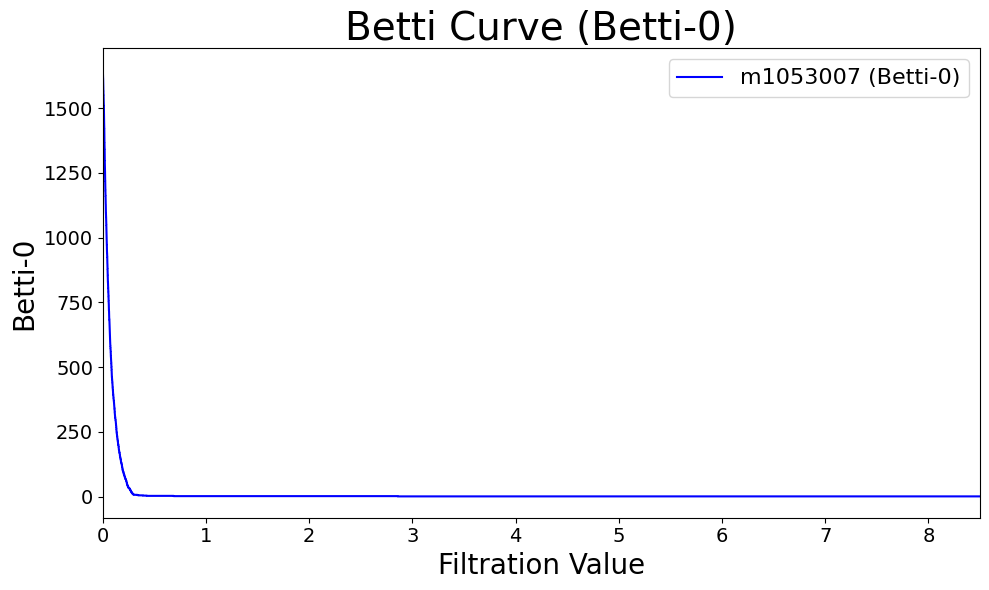

In [93]:
plot_multiple_betti_curves(
    [hyper_curves[0]],
    labels=["m1053007"], dimension = 0,
    title="Betti Curve", limit = [0,8.5]
)

In [ ]:
def plot_named_betti_curves(betti_curves_dict, dimension=0, title='Betti Curves (Dimension 1)'):
    """
    betti_curves_dict: dict of {name: betti_curve_dict}
    Each betti_curve_dict is like {dim: (grid, curve)}
    """
    if len(betti_curves_dict) != 13:
        raise ValueError("Expected 13 Betti curve dicts.")

    plt.figure(figsize=(10, 6))

    for idx, (name, curve_dict) in enumerate(betti_curves_dict.items()):
        if dimension not in curve_dict:
            continue

        grid, curve = curve_dict[dimension]

        if len(grid) == 0:
            continue

        color = 'blue' if idx < 5 else 'red'
        label = name 

        plt.plot(grid, curve, color=color, alpha=0.6, linewidth=1.5, label=label)

    plt.title(title)
    plt.xlabel('Filtration Value')
    plt.ylabel(f'Betti-{dimension}')
    plt.grid(True)

    if plt.gca().get_legend_handles_labels()[0]:
        plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
plot_named_betti_curves(betti_curves, dimension= 1, title='Betti Curves (Dimension 1)')

# Statistical Norm Curve

In [ ]:
def normalize_betti_curves(betti_curves, method='max'):
    """
    Normalize Betti curves using specified method.
    method: 'area' | 'max' | 'sum'
    """
    normalized = {}

    for dim, (grid, curve) in betti_curves.items():
        if len(grid) == 0:
            normalized[dim] = (grid, curve)
            continue

        if method == 'area':
            norm = np.trapezoid(curve, grid)
        elif method == 'max':
            norm = np.max(curve)
        elif method == 'sum':
            norm = np.sum(curve)
        else:
            raise ValueError(f"Unknown normalization method: {method}")

        if norm > 0:
            normalized_curve = curve / norm
        else:
            normalized_curve = curve

        normalized[dim] = (grid, normalized_curve)

    return normalized

def plot_multiple_norm_betti_curves(curves_dicts, labels, dimension, title='Norm Betti Curves Comparison'):
    """
    curves_dicts: list of betti_curve dicts {dim: (grid, curve)}
    labels: list of labels for each curve
    dimension: the Betti number (int) to plot
    """
    plt.figure(figsize=(10, 6))

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']
    linestyles = ['-', '--', '-.', ':']

    for idx, (curve_dict, label) in enumerate(zip(curves_dicts, labels)):
        if dimension in curve_dict:
            grid, curve = curve_dict[dimension]
            if len(grid) > 0:
                color = colors[idx % len(colors)]
                linestyle = linestyles[idx % len(linestyles)]
                plt.plot(grid, curve, color=color, linestyle=linestyle, label=f'{label} (Betti-{dimension})')
        else:
            print(f"Warning: {label} does not contain Betti-{dimension}")

    plt.title(f'{title} (Betti-{dimension})', fontsize=28)
    plt.xlabel('Filtration Value', fontsize=20)
    plt.ylabel(f'Betti-{dimension}', fontsize=20)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=14)
    plt.xlin([0,50])
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [ ]:
norm_betti_curves = {
    name: normalize_betti_curves(diag,method='area')
    for name, diag in betti_curves.items()
}

# Get keys in insertion order
keys = list(betti_curves.keys())

hyper_curves_norm = [norm_betti_curves[k] for k in keys[:5]]
control_curves_norm  = [norm_betti_curves[k] for k in keys[-8:]]

average_control_norm = average_curves(control_curves_norm)
average_hyper_norm = average_curves(hyper_curves_norm)

In [ ]:
plot_multiple_betti_curves(
    [average_hyper_norm, average_control_norm],
    labels=["Hyper", "Control"], dimension = 2,
    title="Comparison of Average Betti Curves"
)

In [ ]:
plot_multiple_betti_curves(
    [control_curves_norm[5]],
    labels=["Hyper"], dimension = 1,
    title=""
)

In [ ]:
dim = 1
ks_results = {}
result = ks_2samp(average_hyper_norm[dim][1], average_control_norm[dim][1])
ks_results[dim] = {
    "statistic": result.statistic,
    "p_value": result.pvalue
}

# Print results
for dim, res in ks_results.items():
    print(f"Dimension {dim}: KS Statistic = {res['statistic']:.4f}, p-value = {res['p_value']:.4e}")

In [ ]:
"""iter(persistence_diagrams)"""

In [ ]:
"""for name, curves in betti_curves.items():
    print(f"\nDataset: {name}")
    print("Dimension | Filtration (alpha^2) | Betti value")
    print("-" * 50)
    
    for dim in sorted(curves.keys()):
        grid, curve = curves[dim]
        print(f"\n--- Dimension {dim} ---")
        for g, b in zip(grid, curve):
            print(f"{dim:<10} {g:<20.5f} {b:<10.0f}")
"""

In [ ]:
"""grid, curve = hyper_curves_norm[0][2]

# Print all pairs
for x, y in zip(grid, curve):
    print(f"x={x:.6f}, y={y:.0f}")"""

In [ ]:
def normalize_betti_curves_for_ks(betti_curves, alpha_max=15, resolution=100000):
    """
    Normalize Betti curves to create proper probability distributions for KS test.
    All curves are defined on the same domain [0, alpha_max].
    """
    normalized = {}
    
    # Create common grid
    common_grid = np.linspace(0, alpha_max, resolution)
    
    for dim, (grid, curve) in betti_curves.items():
        if len(grid) == 0:
            normalized[dim] = (common_grid, np.zeros(resolution))
            continue
        
        # Interpolate onto common grid
        f = interp1d(grid, curve, bounds_error=False, fill_value=0)
        interpolated_curve = f(common_grid)
        
        # Normalize by area (using trapezoidal rule on common grid)
        area = np.trapezoid(interpolated_curve, common_grid)
        
        if area > 0:
            normalized_curve = interpolated_curve / area
        else:
            normalized_curve = interpolated_curve
            
        normalized[dim] = (common_grid, normalized_curve)
    
    return normalized

# Replace your existing normalization code with:
norm_betti_curves = {
    name: normalize_betti_curves_for_ks(trimmed_curves, alpha_max=15)
    for name, trimmed_curves in trimmed_betti_curves.items()
}

# Get keys in insertion order
keys = list(norm_betti_curves.keys())

hyper_curves_norm = [norm_betti_curves[k] for k in keys[:5]]
control_curves_norm = [norm_betti_curves[k] for k in keys[-8:]]

# Average using the same function (it should work now since all have same grid)
average_control_norm = average_curves(control_curves_norm)
average_hyper_norm = average_curves(hyper_curves_norm)

# NOW the KS test makes sense:
dim = 1
# Both curves now have the SAME x-values (common_grid)
# The KS test compares the CDFs, which is appropriate for normalized curves
result = ks_2samp(average_hyper_norm[dim][1], average_control_norm[dim][1])
print(f"Dimension {dim}: KS Statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4e}")

In [ ]:
average_control_norm

In [ ]:
average_hyper_norm

In [ ]:
def save_avg_curve_dict_to_csv(filename, curve_dict):
    """
    curve_dict: {dim: (x_array, y_array)}
    Writes CSV with columns:
        k, dim0, dim1, dim2, ...
    Assumes all dims share the same k grid.
    """
    # Sort dimensions so columns appear in order
    dims = sorted(curve_dict.keys())

    # Extract x from the first dimension
    x = curve_dict[dims[0]][0]

    # Extract y arrays in dimension order
    ys = [curve_dict[d][1] for d in dims]

    # Write CSV
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        header = ["k"] + [f"betti_{d}" for d in dims]
        writer.writerow(header)

        for i in range(len(x)):
            row = [x[i]] + [ys[d_idx][i] for d_idx in range(len(dims))]
            writer.writerow(row)

    print(f"Saved → {filename}")


# Save both averaged curves
save_avg_curve_dict_to_csv("average_hyper_norm.csv", average_hyper_norm)
save_avg_curve_dict_to_csv("average_control_norm.csv", average_control_norm)

# Persistence Landscapes

In [ ]:
def compute_landscape(
    persistence_diagram,
    dim,
    k=5,
    t_min=None,
    t_max=None,
    resolution=500
):
    # Filter and convert to NumPy array
    """diagram = np.array([
        (birth, death)
        for d, (birth, death) in persistence_diagram
        if d == dim and death < float("inf")
    ])"""
    diagram = np.array([
        (birth, death)
        for d, (birth, death) in persistence_diagram
        if d == dim
    ])

    if diagram.shape[0] == 0:
        return None, None

    if t_min is None:
        t_min = diagram[:, 0].min()
    if t_max is None:
        t_max = diagram[:, 1].max()

    landscape = Landscape(
        num_landscapes=k,
        resolution=resolution,
        sample_range=(t_min, t_max)
    )

    # IMPORTANT: input must be a list of NumPy arrays
    landscapes = landscape.fit_transform([diagram])[0]
    landscapes = landscapes.reshape(k, resolution)
    t_vals = np.linspace(t_min, t_max, resolution)

    return t_vals, landscapes

def plot_landscape(t_vals, landscapes, dim, title=None):
    plt.figure(figsize=(8, 5))
    for i, layer in enumerate(landscapes):
        plt.plot(t_vals, layer, label=f"$\\lambda_{{{i+1}}}$")

    plt.xlabel("t")
    plt.ylabel("Landscape value")
    plt.title(title or f"Persistence Landscape (H_{dim})")
    plt.legend()
    plt.tight_layout()
    plt.show()

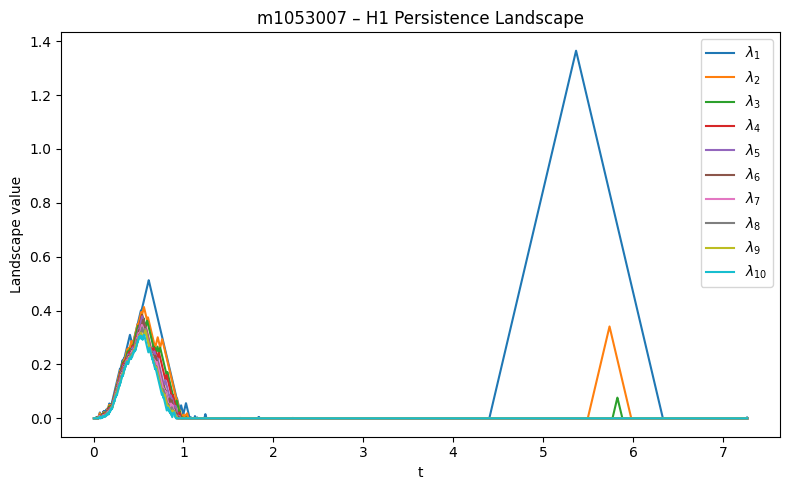

In [95]:
name = "m1053007"
diagram = persistence_diagrams[name]
dimension = 1

t_vals, landscapes = compute_landscape(
    diagram,
    dim=dimension,
    k=10,
    t_min=None,
    t_max=None,
    resolution=10000
)

plot_landscape(
    t_vals,
    landscapes,
    dim=dimension,
    title=f"{name} – H" + str(dimension)+" Persistence Landscape"
)

# Lifespan Curves

In [ ]:
def extract_intervals(persistence_diagram, dim):
    return np.array([
        (b, d)
        for d_dim, (b, d) in persistence_diagram
        if d_dim == dim and np.isfinite(d)
    ])

def lifespan_curve(
    persistence_diagram,
    dim,
    t_min=None,
    t_max=None,
    resolution=500
):
    intervals = extract_intervals(persistence_diagram, dim)

    if intervals.size == 0:
        return None, None

    births = intervals[:, 0]
    deaths = intervals[:, 1]
    lifespans = deaths - births

    if t_min is None:
        t_min = births.min()
    if t_max is None:
        t_max = deaths.max()

    t_vals = np.linspace(t_min, t_max, resolution)

    LC = np.zeros_like(t_vals)
    for i, t in enumerate(t_vals):
        alive = (births <= t) & (t < deaths)
        LC[i] = lifespans[alive].sum()

    return t_vals, LC

def plot_lifespan_curve(t_vals, LC, dim, title=None):
    plt.figure(figsize=(7, 4))
    plt.plot(t_vals, LC)
    plt.xlabel("Filtration parameter t")
    plt.ylabel("Sum of lifespans of alive features")
    plt.title(title or f"Lifespan Curve (H_{dim})")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [1]:
name = "m1053007"
diagram = persistence_diagrams[name]
dimension = 0

t_vals_L, L = lifespan_curve(
    diagram,
    dim=dimension,
    resolution=10000
)

plot_lifespan_curve(
    t_vals_L,
    L,
    dim=dimension,
    title=f"{name} – H" + str(dimension)+" Lifespan Curve"
)


NameError: name 'persistence_diagrams' is not defined

# Norm Lifespan Curves

In [ ]:
def norm_lifespan_curve(
    persistence_diagram,
    dim,
    t_min=None,
    t_max=None,
    resolution=500
):
    intervals = extract_intervals(persistence_diagram, dim)

    if intervals.size == 0:
        return None, None

    births = intervals[:, 0]
    deaths = intervals[:, 1]
    lifespans = deaths - births

    if t_min is None:
        t_min = births.min()
    if t_max is None:
        t_max = deaths.max()

    t_vals = np.linspace(t_min, t_max, resolution)

    total_lifespan = lifespans.sum()  # sum over all bars

    LC = np.zeros_like(t_vals)
    for i, t in enumerate(t_vals):
        alive = (births <= t) & (t < deaths)
        LC[i] = lifespans[alive].sum() / total_lifespan

    return t_vals, LC

def plot_norm_lifespan_curve(t_vals, LC, dim, title=None):
    plt.figure(figsize=(7, 4))
    plt.plot(t_vals, LC)
    plt.xlabel("Filtration parameter t")
    plt.ylabel("Sum of lifespans of alive features")
    plt.title(title or f"Lifespan Curve (H_{dim})")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

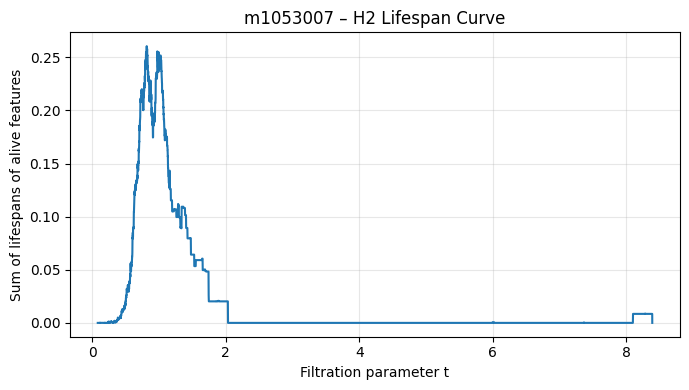

In [82]:
name = "m1053007"
diagram = persistence_diagrams[name]
dimension = 2

t_vals_Lnorm, Lnorm = norm_lifespan_curve(
    diagram,
    dim=dimension,
    resolution=10000
)

plot_norm_lifespan_curve(
    t_vals_Lnorm,
    Lnorm,
    dim=dimension,
    title=f"{name} – H" + str(dimension)+" Lifespan Curve"
)


In [83]:
scipy.integrate.trapezoid(Lnorm, t_vals_Lnorm)

np.float64(0.169060265936879)